* Peak gene association 
* DORC comparison


# Imports

In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
import scanpy as sc
import pyranges as pr
import warnings

In [3]:
import palantir 
import phenograph
import harmony

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [4]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['image.cmap'] = 'Spectral_r'
matplotlib.rcParams["font.family"] = "Helvetica"

In [6]:
%env R_HOME=/usr/lib64/R

env: R_HOME=/usr/lib64/R


In [7]:
plot_prefix = 'plots/Fig3_'

# Utility functions

In [8]:
def log_transform(ad, ps=0.1):
    ad.X.data = np.log2(ad.X.data + ps) - np.log2(ps)

In [9]:
from joblib import Parallel, delayed
from scipy.sparse import hstack, csr_matrix, issparse
import gc


def _dot_func(x, y):
    return x.dot(y)


def impute_data(dm_res, ad, n_steps=3):
    T_steps = dm_res['T'] ** n_steps
    T_steps = T_steps.astype(np.float32)

    # RUn in parallel
    seq = np.append(np.arange(0, ad.X.shape[1], 100), [ad.X.shape[1]])
    res = Parallel(n_jobs=-1)(delayed(_dot_func)(T_steps, ad.X[:, seq[i - 1]:seq[i]]) for i in range(1, len(seq)))
    imputed_data = hstack(res)
    imputed_data = imputed_data.todense()
    imputed_data[imputed_data < 1e-2] = 0
    gc.collect()

    return imputed_data

In [10]:
def pyranges_from_strings(pos_list):
    # Chromosome and positions
    chr = pos_list.str.split(':').str.get(0)
    start = pd.Series(pos_list.str.split(':').str.get(1)).str.split('-').str.get(0)
    end = pd.Series(pos_list.str.split(':').str.get(1)).str.split('-').str.get(1)
    
    # Create ranges
    gr = pr.PyRanges(chromosomes=chr, starts=start, ends=end)
    
    return gr


def pyranges_to_strings(peaks):
    # Chromosome and positions
    chr = peaks.Chromosome.astype(str).values
    start = peaks.Start.astype(str).values
    end = peaks.End.astype(str).values
    
    # Create ranges
    gr = chr + ':' + start + '-' + end
    
    return gr

In [11]:
def plot_gene_expression(
    data,
    tsne,
    genes,
    plot_scale=False,
    n_cols=5,
    percentile=0,
    s=3,
    cmap=matplotlib.cm.Spectral_r,
):
    """ Plot gene expression on tSNE maps
    :param genes: Iterable of strings to plot on tSNE
    """

    not_in_dataframe = set(genes).difference(data.columns)
    if not_in_dataframe:
        if len(not_in_dataframe) < len(genes):
            print(
                "The following genes were either not observed in the experiment, "
                "or the wrong gene symbol was used: {!r}".format(not_in_dataframe)
            )
        else:
            print(
                "None of the listed genes were observed in the experiment, or the "
                "wrong symbols were used."
            )
            return

    # remove genes missing from experiment
    genes = pd.Series(genes)[pd.Series(genes).isin(data.columns)]

    # Plot
    cells = data.index.intersection(tsne.index)
    fig = palantir.plot.FigureGrid(len(genes), n_cols)

    for g, ax in zip(genes, fig):
        # Data
        c = data.loc[cells, g]
        vmin = np.percentile(c[~np.isnan(c)], percentile)
        vmax = np.percentile(c[~np.isnan(c)], 100 - percentile)

        ax.scatter(
            tsne.loc[cells, "x"],
            tsne.loc[cells, "y"],
            s=s,
            c=c,
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
        )
        ax.set_axis_off()
        ax.set_title(g)

        if plot_scale:
            normalize = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
            cax, _ = matplotlib.colorbar.make_axes(ax)
            matplotlib.colorbar.ColorbarBase(cax, norm=normalize, cmap=cmap)



In [12]:

def plot_gene_trends(gene_trends, genes=None, colors=None, plot_std=True):
    """ Plot the gene trends: each gene is plotted in a different panel
    :param: gene_trends: Results of the compute_marker_trends function
    """

    # Branches and genes
    branches = list(gene_trends.keys())
    if colors is None:
        colors = pd.Series(
            sns.color_palette("Set2", len(branches)).as_hex(), index=branches
        )
    if genes is None:
        genes = gene_trends[branches[0]]["trends"].index

    # Set up figure
    fig = plt.figure(figsize=[7, 3 * len(genes)])
    for i, gene in enumerate(genes):
        ax = fig.add_subplot(len(genes), 1, i + 1)
        for branch in branches:
            trends = gene_trends[branch]["trends"]
            stds = gene_trends[branch]["std"]
            ax.plot(
                trends.columns, trends.loc[gene, :], color=colors[branch], label=branch
            )
            ax.set_xticks([0, 1])
            if plot_std:
                ax.fill_between(
                    trends.columns,
                    trends.loc[gene, :] - stds.loc[gene, :],
                    trends.loc[gene, :] + stds.loc[gene, :],
                    alpha=0.1,
                    color=colors[branch],
                )
            ax.set_title(gene)
        # Add legend
        if i == 0:
            ax.legend()

    sns.despine()


In [13]:
def _gam_fit_predict(x, y, weights=None, pred_x=None):

    import rpy2.robjects as robjects
    from rpy2.robjects import pandas2ri, Formula
    from rpy2.robjects.packages import importr

    pandas2ri.activate()

    # Weights
    if weights is None:
        weights = np.repeat(1.0, len(x))

#     gam = LinearGAM(s(0)).fit(x, y)    
#     y_pred = gam.predict(pred_x)
#     return y_pred, 0
    
    # Construct dataframe
    use_inds = np.where(weights > 0)[0]
    r_df = pandas2ri.py2rpy(
        pd.DataFrame(np.array([x, y]).T[use_inds, :], columns=["x", "y"])
    )

    # Fit the model
    rgam = importr("gam")
    model = rgam.gam(Formula("y~s(x, 3)"), data=r_df, weights=pd.Series(weights[use_inds]))

    # Predictions
    if pred_x is None:
        pred_x = x
    y_pred = np.array(
        robjects.r.predict(
            model, newdata=pandas2ri.py2rpy(pd.DataFrame(pred_x, columns=["x"]))
        )
    )

    # Standard deviations
    p = np.array(
        robjects.r.predict(
            model, newdata=pandas2ri.py2rpy(pd.DataFrame(x[use_inds], columns=["x"]))
        )
    )
    n = len(use_inds)
    sigma = np.sqrt(((y[use_inds] - p) ** 2).sum() / (n - 2))
    stds = (
        np.sqrt(1 + 1 / n + (pred_x - np.mean(x)) ** 2 / ((x - np.mean(x)) ** 2).sum())
        * sigma
        / 2
    )

    return y_pred, stds


# Load data

In [14]:
data_dir = os.path.expanduser('/home/ec2-user/projects/metacells/data/CD34/Multiome/')

In [15]:
rna_ad = sc.read(data_dir + 'cd34_multiome_rna_no_bcells.h5ad')
atac_ad = sc.read(data_dir + 'cd34_multiome_atac_no_bcells.h5ad')
atac_archr_vanilla = sc.read(data_dir + 'cd34_multiome_atac_no_bcells_archr_vanilla.h5ad')

In [16]:
rna_ad

AnnData object with n_obs × n_vars = 6881 × 12464
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype', 'Metacell', 'palantir_pseudotime', 'palantir_diff_potential', 'Metacell_Entropy'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'DMEigenValues', 'celltype_colors', 'ct_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'palantir_branch_probs_columns', 'pca', 'phenograph_colors', 'sample_colors', 'umap'
    obsm: 'DM_EigenVectors', 'X_FDL', 'X_pca', 'X_umap', 'palantir_branch_probs'
    varm: 'PCs'
    layers: 'MAGIC_imputed_data'
    obsp: 'DM_Kernel', 'connectivities', 'distances'

In [17]:
# Diffusion maps object
dm_res = dict()
dm_res['EigenVectors'] = pd.DataFrame(rna_ad.obsm['DM_EigenVectors'], 
                                     index=rna_ad.obs_names)
dm_res['EigenValues'] = rna_ad.uns['DMEigenValues']
dm_res['kernel'] = rna_ad.obsp['DM_Kernel']

In [18]:
# Diffusion maps object
atac_dm_res = dict()
atac_dm_res['EigenVectors'] = pd.DataFrame(atac_ad.obsm['DM_EigenVectors'], 
                                     index=atac_ad.obs_names)
atac_dm_res['EigenValues'] = atac_ad.uns['DM_EigenValues']
atac_dm_res['kernel'] = atac_ad.obsp['DM_kernel']

In [19]:
ct_colors = pd.Series(rna_ad.uns['celltype_colors'], 
                     index=rna_ad.obs['celltype'].values.categories)

## ATAC TF-IDF

In [20]:
from sklearn.feature_extraction.text import TfidfTransformer

In [21]:
tfidf = TfidfTransformer()
tfidf.fit(atac_ad.X)
atac_ad.layers['TFIDF'] = tfidf.transform(atac_ad.X)

In [22]:
tfidf = TfidfTransformer()
tfidf.fit(atac_archr_vanilla.X)
atac_archr_vanilla.layers['TFIDF'] = tfidf.transform(atac_archr_vanilla.X)

## ATAC Meta cell 

In [23]:
from tqdm.notebook import tqdm

In [24]:
# Summary matrix
metacells = atac_ad.obs['Metacell'].astype(str).unique()
summ_matrix = pd.DataFrame(0.0, index=metacells, columns=atac_ad.var_names)

for m in summ_matrix.index:
    cells = atac_ad.obs_names[atac_ad.obs['Metacell'] == m]
    summ_matrix.loc[m, :] = np.ravel(atac_ad[cells, :].X.sum(axis=0))

In [25]:
# Ann data
# Counts
atac_meta_ad = sc.AnnData(summ_matrix)
atac_meta_ad.X = csr_matrix(atac_meta_ad.X)
atac_meta_ad.obs_names, atac_meta_ad.var_names = summ_matrix.index.astype(str), atac_ad.var_names

In [26]:
atac_meta_ad.raw = sc.AnnData(atac_meta_ad.X)

In [27]:
sc.pp.normalize_per_cell(atac_meta_ad)

In [28]:
atac_ad.obs['RNAMetacell'] = rna_ad.obs['Metacell']

## RNA meta cell

In [29]:
# Summary matrix
metacells = atac_ad.obs['Metacell'].astype(str).unique()
summ_matrix = pd.DataFrame(0.0, index=metacells, columns=rna_ad.var_names)

for m in tqdm(summ_matrix.index):
    cells = rna_ad.obs_names[atac_ad.obs['Metacell'] == m]
    summ_matrix.loc[m, :] = np.ravel(rna_ad[cells, :].X.sum(axis=0))

In [30]:
# Ann data
# Counts
rna_meta_ad = sc.AnnData(summ_matrix)
rna_meta_ad.X = csr_matrix(rna_meta_ad.X)
rna_meta_ad.obs_names, rna_meta_ad.var_names = summ_matrix.index.astype(str), rna_meta_ad.var_names

In [31]:
rna_meta_ad.raw = sc.AnnData(rna_meta_ad.X)

In [32]:
sc.pp.normalize_per_cell(rna_meta_ad)

In [33]:
rna_meta_ad.obs['palantir_pseudotime'] = rna_ad.obs['palantir_pseudotime'].groupby(atac_ad.obs['Metacell']).mean()[rna_meta_ad.obs_names]

In [34]:
atac_meta_ad

AnnData object with n_obs × n_vars = 100 × 246113
    obs: 'n_counts'

In [35]:
rna_meta_ad

AnnData object with n_obs × n_vars = 100 × 12464
    obs: 'n_counts', 'palantir_pseudotime'

## TFs

In [36]:
human_tfs = pd.read_csv('/home/ec2-user/data/AnimalTFDB/Homo_sapiens.txt', sep='\t')['Symbol'].unique()

# Expression -vs- accessibility

## Load results

In [37]:
dorc_dir = os.path.expanduser('~/projects/metacells/data/CD34/Multiome/outs/')

In [38]:
gene_res = pd.read_pickle(dorc_dir + 'cd34_meta_dorc_correlations.p')
gene_scores = pd.read_pickle(dorc_dir + 'cd34_meta_dorc_gene_scores.p')

In [39]:
sc_gene_res = pd.read_pickle(dorc_dir + 'cd34_sc_correlations.p')
sc_gene_scores = pd.read_pickle(dorc_dir + 'cd34_sc_gene_scores.p')

In [40]:
sc_gs_ad = sc.read(dorc_dir + 'cd34_sc_gs.h5ad')
meta_gs_ad = sc.read(dorc_dir + 'cd34_meta_gs.h5ad')

In [41]:
tanay_gene_res = pd.read_pickle(dorc_dir + 'tanay_mc_correlations.p')
tanay_gene_scores = pd.read_pickle(dorc_dir + 'tanay_mc_gene_scores.p')
tanay_ad = sc.read(dorc_dir + 'tanay.h5ad')

In [42]:
supercell_gene_res = pd.read_pickle(dorc_dir + 'supercell_correlations.p')
supercell_gene_scores = pd.read_pickle(dorc_dir + 'supercell_gene_scores.p')
supercell_ad = sc.read(dorc_dir + 'supercells.h5ad')

## Specific examples

In [45]:
from scipy.stats import pearsonr, spearmanr

TAL1: 0.8274
MPO: 0.7518
IRF8: 0.7203


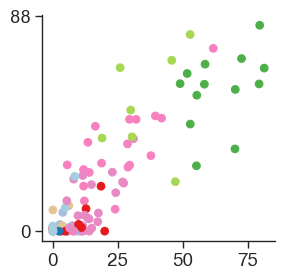

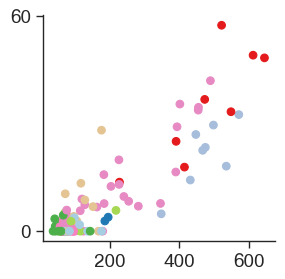

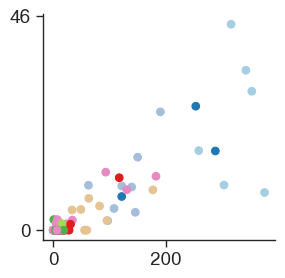

In [46]:
genes = ['TAL1', 'MPO', 'IRF8']

for gene in genes:
    
    # Correlated peaks
    p = gene_res[gene]['cor'].idxmax()
    
    plt.figure(figsize=[3, 3])
    plt.scatter(np.ravel(rna_meta_ad[:, gene].X.todense()), 
               np.ravel(atac_meta_ad[:, p].X.todense()), 
                s=30, #edgecolor='black', linewidths=0.5,
               color=ct_colors[rna_ad.obs['celltype'][atac_meta_ad.obs_names]])
    ax = plt.gca()
    sns.despine()
    # plt.xlabel('Metacell expression')
    # plt.ylabel('Metacell accessibility')

    corr = spearmanr(np.ravel(rna_meta_ad[:, gene].X.todense()), 
               np.ravel(atac_meta_ad[:, p].X.todense()))[0]
    print(f'{gene}: {corr:.4f}')
#     plt.xticks([0, int((plt.xlim()[1]))])
#     if gene == 'TAL1':
#         plt.ylim([plt.ylim()[0], 50])
    plt.yticks([0, int(plt.ylim()[1])])

    plt.savefig(plot_prefix + f'dorc_corrs_meta_{gene}.png', dpi=150)

In [ ]:
for gene in genes:
    
    # Correlated peaks
    p =sc_gene_res[gene]['cor'].idxmax()
    
    plt.figure(figsize=[3, 3])
    plt.scatter(np.ravel(rna_ad[:, gene].X.todense()), 
               np.ravel(atac_archr_vanilla[:, p].layers['TFIDF'].todense()), s=8,
               color=ct_colors[rna_ad.obs['celltype'][atac_ad.obs_names]])
    ax = plt.gca()
    sns.despine()
    # plt.xlabel('Single cell expression')
    # plt.ylabel('Single cell accessibility')

    corr = spearmanr(np.ravel(rna_ad[:, gene].X.todense()), 
               np.ravel(atac_archr_vanilla[:, p].layers['TFIDF'].todense()))[0]

    print(f'{gene}: {corr:.4f}')
    plt.xticks([0, int((plt.xlim()[1]))])
    plt.yticks([0, 0.035])

    plt.savefig(plot_prefix + f'dorc_corrs_sc_{gene}.png', dpi=150)


In [77]:
from scipy.stats import pearsonr, spearmanr

In [78]:
genes = ['TAL1', 'MPO', 'IRF8']

TAL1: 0.4549
TAL1: 0.7023
MPO: 0.6714
MPO: 0.7461
IRF8: 0.9505
IRF8: 0.7732


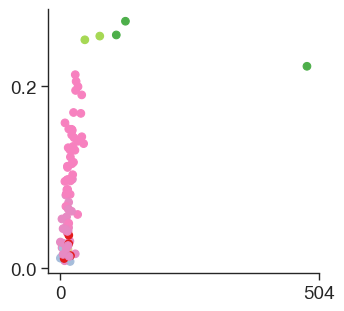

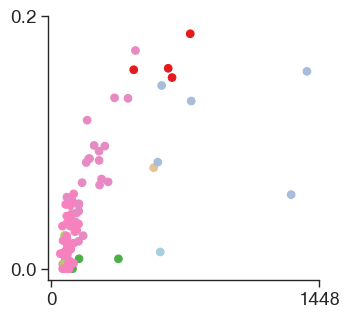

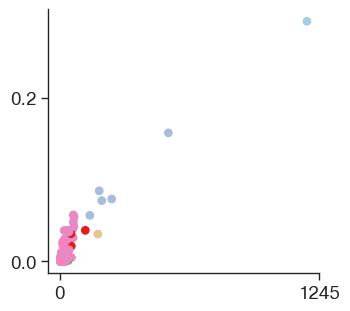

In [48]:
# tanay
t_atac_meta_exprs = pd.DataFrame(tanay_ad.X.todense(), 
                              index=tanay_ad.obs_names, columns=tanay_ad.var_names)

t_rna_exprs = pd.DataFrame(tanay_ad.obsm['GeneExpression'], 
                         index=tanay_ad.obs_names, columns=tanay_ad.uns['GeneExpressionColumns'])


for gene in genes:
    
    # Correlated peaks
    p = tanay_gene_res[gene]['cor'].idxmax()

    x = t_rna_exprs.loc[:, gene]
    y = t_atac_meta_exprs.loc[:, p]
    
    plt.figure(figsize=[3.5, 3.5])
    ax = plt.gca()
    ax.scatter(x, y, 
                    s=30, #edgecolor='black', linewidths=0.5,
                   color=ct_colors[tanay_ad.obs['celltype'][x.index].values])
    sns.despine()
    # plt.xlabel('Single cell expression')
    # plt.ylabel('Single cell accessibility')

    corr = pearsonr(x, y)[0]
    s_corr = spearmanr(x, y)[0]

    print(f'{gene}: {corr:.4f}')
    print(f'{gene}: {s_corr:.4f}')
    plt.xticks([0, int((plt.xlim()[1]))])
    plt.yticks([0, 0.2])

    plt.savefig(plot_prefix + f'dorc_corrs_tanay_{gene}.png', dpi=150)


TAL1: 0.4751
MPO: 0.4663
IRF8: 0.3770


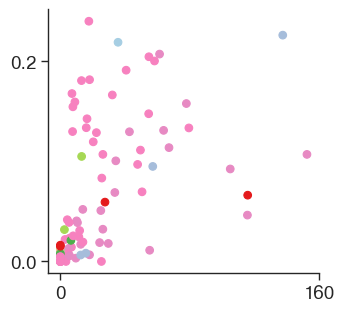

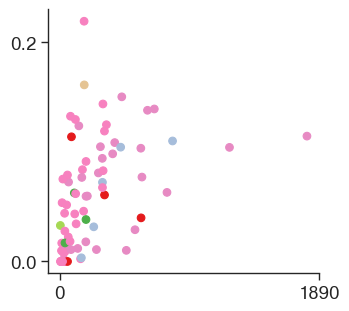

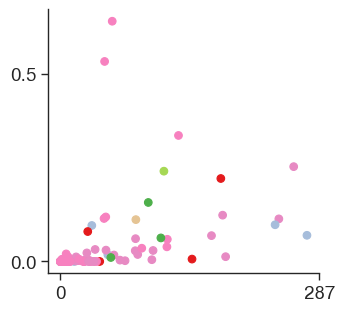

In [49]:
# Supercell
s_atac_meta_exprs = pd.DataFrame(supercell_ad.X.todense(), 
                              index=supercell_ad.obs_names, columns=supercell_ad.var_names)

s_rna_exprs = pd.DataFrame(supercell_ad.obsm['GeneExpression'], 
                         index=supercell_ad.obs_names, columns=supercell_ad.uns['GeneExpressionColumns'])

for gene in genes:
    
    # Correlated peaks
    p = supercell_gene_res[gene]['cor'].idxmax()

    x = s_rna_exprs.loc[:, gene]
    y = s_atac_meta_exprs.loc[:, p]
    
    plt.figure(figsize=[3.5, 3.5])
    ax = plt.gca()
    ax.scatter(x, y, 
                    s=30, #edgecolor='black', linewidths=0.5,
                   color=ct_colors[tanay_ad.obs['celltype'][x.index].values])
    sns.despine()
    # plt.xlabel('Single cell expression')
    # plt.ylabel('Single cell accessibility')

    corr = pearsonr(x, y)[0]

    print(f'{gene}: {corr:.4f}')
    plt.xticks([0, int((plt.xlim()[1]))])
    plt.yticks([0, 0.2])
    if gene == 'IRF8':
        plt.yticks([0, 0.5])

    plt.savefig(plot_prefix + f'dorc_corrs_supercell_{gene}.png', dpi=150)


## Larger gene set

In [52]:
import matplotlib.gridspec as gridspec


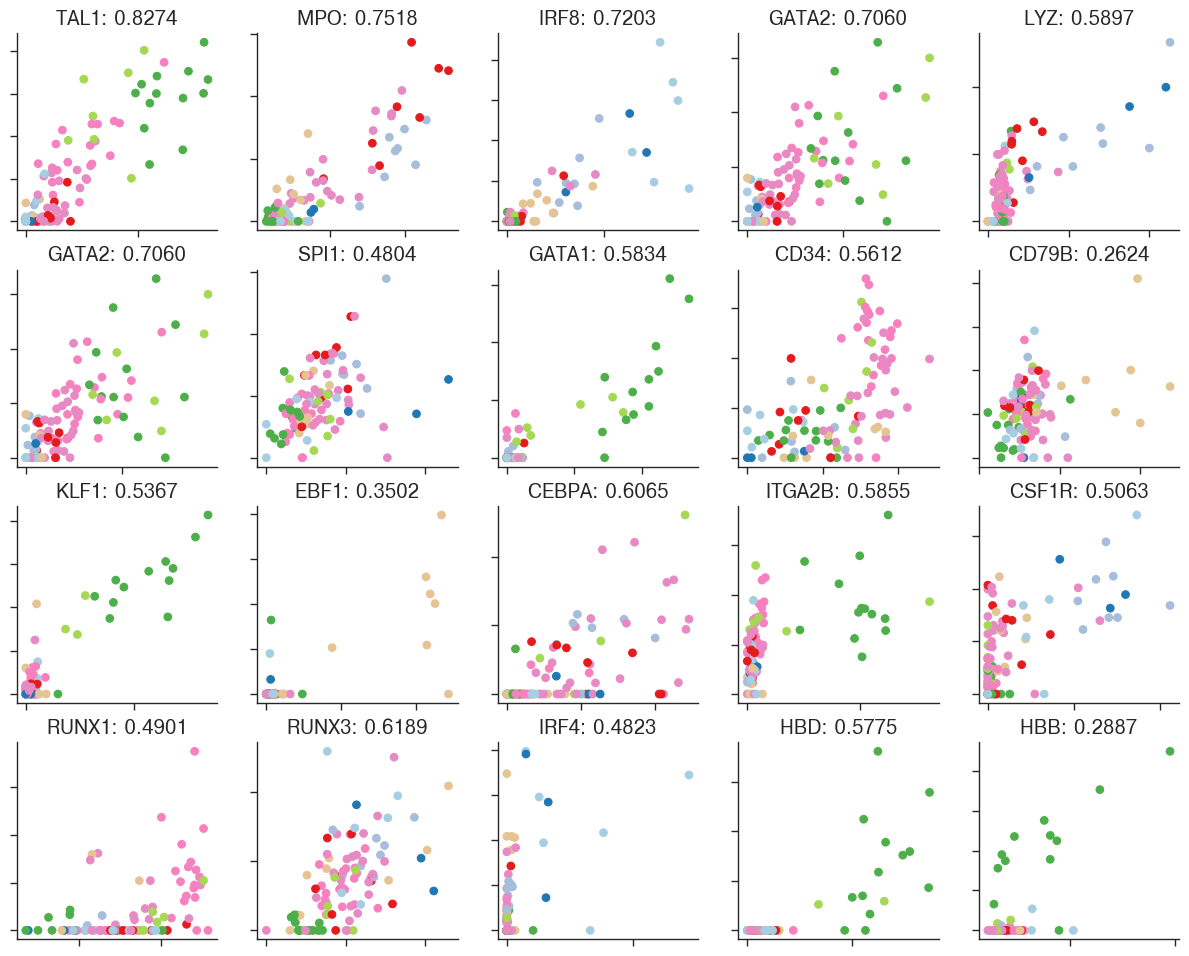

In [56]:
# genes = [ #'TAL1', 'MPO', 'IRF8', 'GATA2', 'TAL1',
#     'GATA2', 'SPI1', 
#          'GATA1', 'CD34', 'CD79B', 'KLF1', 'EBF1', 
#          'CEBPA', 'ITGA2B', 'CSF1R', 'RUNX1', 'RUNX3', 
#          'IRF4', 'SAMHD1', 'LYZ', 
#          'GPC5', 'CUX2', 'FCER1A', 'ANK3', 'BLNK', 
#          'LGALS1', 'BMP6', 'HBD', 'PBX1', 'FREM1']
# genes = np.array(genes).reshape([5, 5])
# fig = plt.figure(figsize=[3 * 5, 3 * 5])

genes = [ 'TAL1', 'MPO', 'IRF8', 'GATA2', 'LYZ',
          'GATA2', 'SPI1', 'GATA1', 'CD34', 'CD79B', 
         'KLF1', 'EBF1', 'CEBPA', 'ITGA2B', 'CSF1R', 
         'RUNX1', 'RUNX3', 'IRF4', 'HBD', 'HBB']


genes = np.array(genes).reshape([4, 5])
fig = plt.figure(figsize=[3 * 5, 3 * 4])
gs = gridspec.GridSpec(genes.shape[0], genes.shape[1])

for i in range(genes.shape[0]):
    for j in range(genes.shape[1]):
        ax = fig.add_subplot(gs[i, j])
        gene = genes[i, j]

        # Correlated peaks
        p = gene_res[gene]['cor'].idxmax()

        x = pd.Series(np.ravel(rna_meta_ad[:, gene].X.todense()), 
                     index=rna_meta_ad.obs_names)
        y = pd.Series(np.ravel(atac_meta_ad[:, p].X.todense()), 
                     index=atac_meta_ad.obs_names)
        
        if gene in ['LYZ', 'KLF1', 'CEBPA']:
            rem = y.idxmax()
            x = x[x.index.difference([rem])]
            y = y[x.index]
        
        ax.scatter(x, y, 
                    s=30, #edgecolor='black', linewidths=0.5,
                   color=ct_colors[rna_ad.obs['celltype'][x.index]])
        sns.despine()
        # plt.xlabel('Metacell expression')
        # plt.ylabel('Metacell accessibility')

        corr = spearmanr(x, y)[0]
        ax.set_title(f'{gene}: {corr:.4f}')
    #     plt.xticks([0, int((plt.xlim()[1]))])
    #     if gene == 'TAL1':
    #         plt.ylim([plt.ylim()[0], 50])
        ax.set_yticklabels([])
        ax.set_xticklabels([])
plt.savefig(plot_prefix + 'Supp_SEACells_gene_set.png', dpi=150)

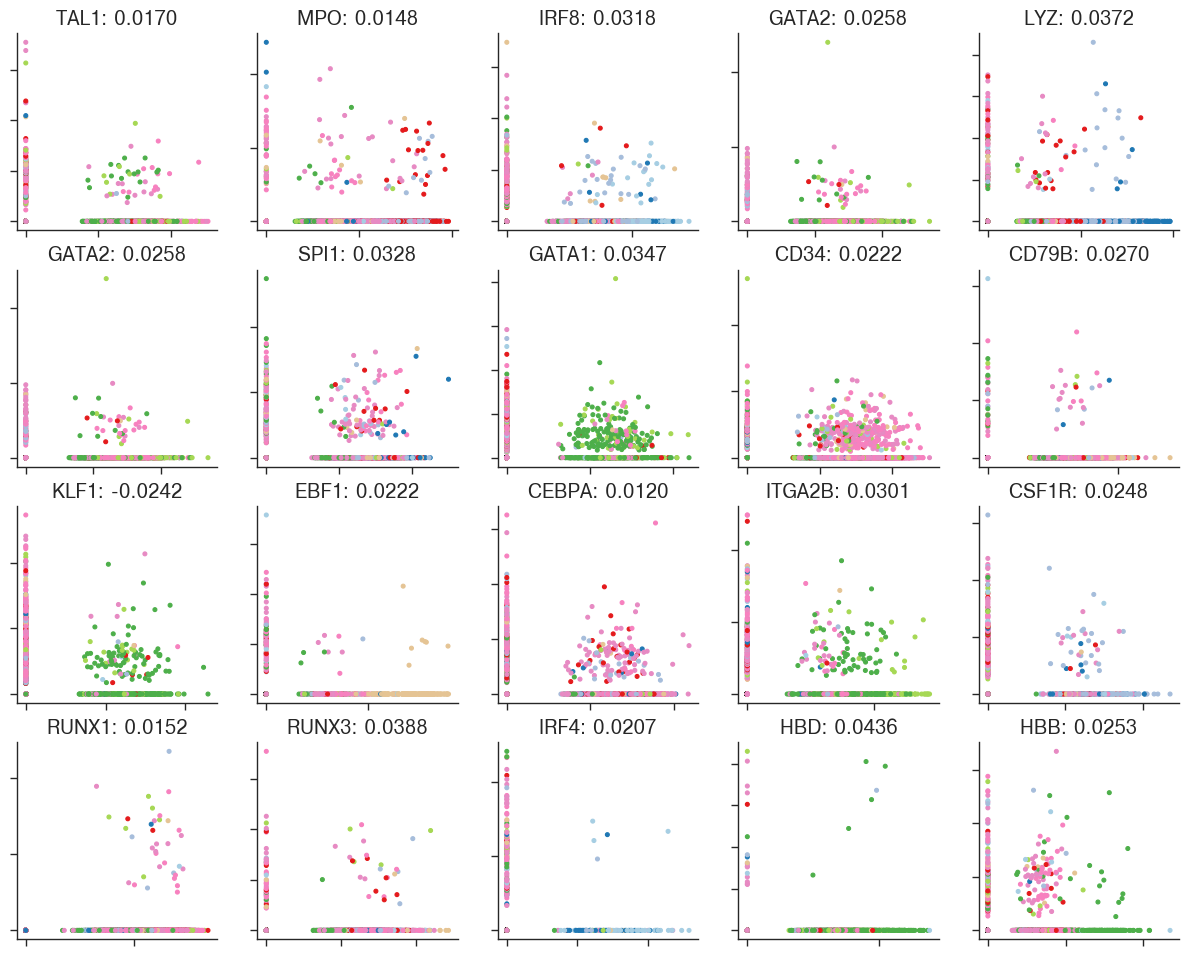

In [48]:
fig = plt.figure(figsize=[3 * 5, 3 * 4])
gs = gridspec.GridSpec(genes.shape[0], genes.shape[1])

for i in range(genes.shape[0]):
    for j in range(genes.shape[1]):
        ax = fig.add_subplot(gs[i, j])
        gene = genes[i, j]

        # Correlated peaks
        p = sc_gene_res[gene]['cor'].idxmax()
               
        x = pd.Series(np.ravel(rna_ad[:, gene].X.todense()), 
                     index=rna_ad.obs_names)
        y = pd.Series(np.ravel(atac_archr_vanilla[:, p].layers['TFIDF'].todense()), 
                     index=atac_archr_vanilla.obs_names)
        
        if gene in ['LYZ', 'KLF1', 'CEBPA']:
            rem = y.idxmax()
            x = x[x.index.difference([rem])]
            y = y[x.index]
        
        ax.scatter(x, y, 
                    s=8, #edgecolor='black', linewidths=0.5,
                   color=ct_colors[rna_ad.obs['celltype'][x.index]])
        sns.despine()
        # plt.xlabel('Metacell expression')
        # plt.ylabel('Metacell accessibility')

        corr = pearsonr(x, y)[0]
        ax.set_title(f'{gene}: {corr:.4f}')
    #     plt.xticks([0, int((plt.xlim()[1]))])
    #     if gene == 'TAL1':
    #         plt.ylim([plt.ylim()[0], 50])
        ax.set_yticklabels([])
        ax.set_xticklabels([])
plt.savefig(plot_prefix + 'Supp_SingleCells_gene_set.png', dpi=150)

### Tanay metacells

In [58]:
atac_meta_exprs = pd.DataFrame(tanay_ad.X.todense(), 
                              index=tanay_ad.obs_names, columns=tanay_ad.var_names)

rna_exprs = pd.DataFrame(tanay_ad.obsm['GeneExpression'], 
                         index=tanay_ad.obs_names, columns=tanay_ad.uns['GeneExpressionColumns'])

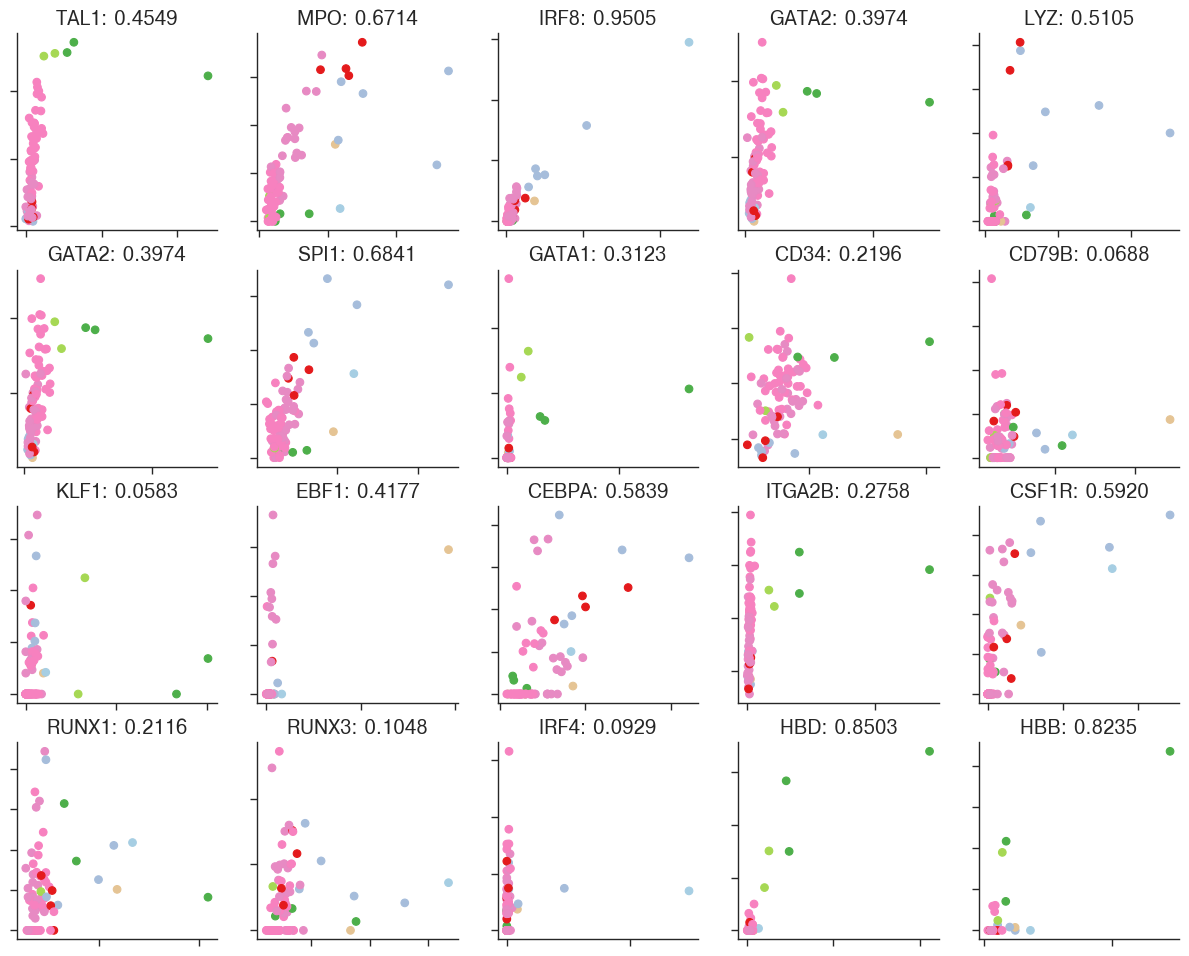

In [59]:
genes = [ 'TAL1', 'MPO', 'IRF8', 'GATA2', 'LYZ',
          'GATA2', 'SPI1', 'GATA1', 'CD34', 'CD79B', 
         'KLF1', 'EBF1', 'CEBPA', 'ITGA2B', 'CSF1R', 
         'RUNX1', 'RUNX3', 'IRF4', 'HBD', 'HBB']
#          'GPC5', 'CUX2', 'FCER1A', 'ANK3', 'BLNK', 
#          'LGALS1', 'BMP6', 'HBD', 'PBX1', 'FREM1']
genes = np.array(genes).reshape([4, 5])

fig = plt.figure(figsize=[3 * 5, 3 * 4])
gs = gridspec.GridSpec(genes.shape[0], genes.shape[1])

for i in range(genes.shape[0]):
    for j in range(genes.shape[1]):
        ax = fig.add_subplot(gs[i, j])
        gene = genes[i, j]

        # Correlated peaks
        p = tanay_gene_res[gene]['cor'].idxmax()

        x = rna_exprs.loc[:, gene]
        y = atac_meta_exprs.loc[:, p]
        
        if gene in ['LYZ', 'KLF1', 'CEBPA']:
            rem = y.idxmax()
            x = x[x.index.difference([rem])]
            y = y[x.index]
        
        ax.scatter(x, y, 
                    s=30, #edgecolor='black', linewidths=0.5,
                   color=ct_colors[tanay_ad.obs['celltype'][x.index].values])
        sns.despine()
        # plt.xlabel('Metacell expression')
        # plt.ylabel('Metacell accessibility')

        corr = pearsonr(x, y)[0]
        ax.set_title(f'{gene}: {corr:.4f}')
#         ax.set_title(f'{gene}')
    #     plt.xticks([0, int((plt.xlim()[1]))])
    #     if gene == 'TAL1':
    #         plt.ylim([plt.ylim()[0], 50])
        ax.set_yticklabels([])
        ax.set_xticklabels([])
plt.savefig(plot_prefix + 'Supp_TanayCells_gene_set.png', dpi=150)

### Supercells

In [60]:
atac_meta_exprs = pd.DataFrame(supercell_ad.X.todense(), 
                              index=supercell_ad.obs_names, columns=supercell_ad.var_names)

rna_exprs = pd.DataFrame(supercell_ad.obsm['GeneExpression'], 
                         index=supercell_ad.obs_names, columns=supercell_ad.uns['GeneExpressionColumns'])

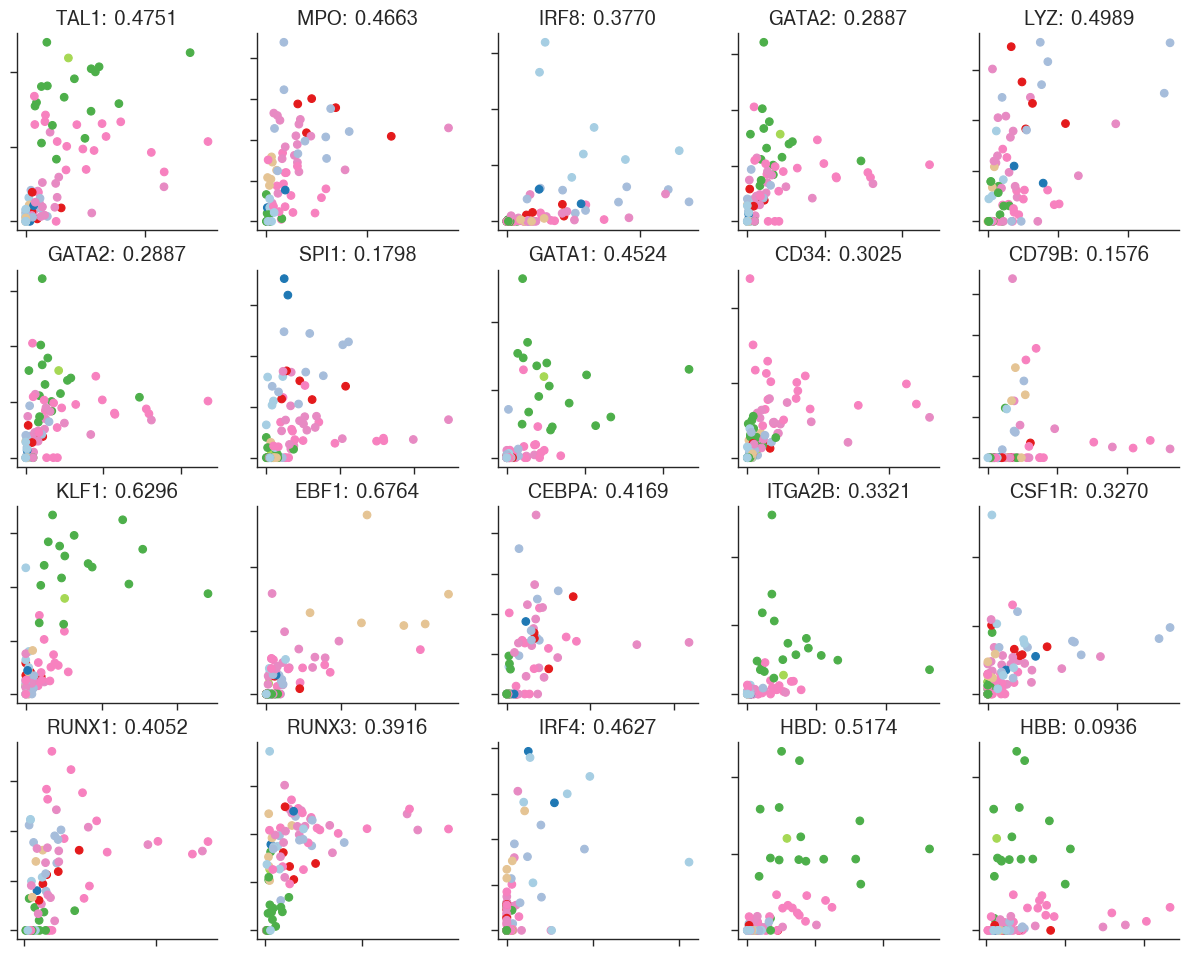

In [62]:
genes = [ 'TAL1', 'MPO', 'IRF8', 'GATA2', 'LYZ',
          'GATA2', 'SPI1', 'GATA1', 'CD34', 'CD79B', 
         'KLF1', 'EBF1', 'CEBPA', 'ITGA2B', 'CSF1R', 
         'RUNX1', 'RUNX3', 'IRF4', 'HBD', 'HBB']
#          'GPC5', 'CUX2', 'FCER1A', 'ANK3', 'BLNK', 
#          'LGALS1', 'BMP6', 'HBD', 'PBX1', 'FREM1']
genes = np.array(genes).reshape([4, 5])

fig = plt.figure(figsize=[3 * 5, 3 * 4])
gs = gridspec.GridSpec(genes.shape[0], genes.shape[1])

for i in range(genes.shape[0]):
    for j in range(genes.shape[1]):
        ax = fig.add_subplot(gs[i, j])
        gene = genes[i, j]

        # Correlated peaks
        p = supercell_gene_res[gene]['cor'].idxmax()

        x = rna_exprs.loc[:, gene]
        y = atac_meta_exprs.loc[:, p]
        
        if gene in ['LYZ', 'KLF1', 'CEBPA']:
            rem = y.idxmax()
            x = x[x.index.difference([rem])]
            y = y[x.index]
        
        ax.scatter(x, y, 
                    s=30, #edgecolor='black', linewidths=0.5,
                   color=ct_colors[supercell_ad.obs['celltype'][x.index].values])
        sns.despine()
        # plt.xlabel('Metacell expression')
        # plt.ylabel('Metacell accessibility')

        corr = pearsonr(x, y)[0]
        ax.set_title(f'{gene}: {corr:.4f}')
#         ax.set_title(f'{gene}')
    #     plt.xticks([0, int((plt.xlim()[1]))])
    #     if gene == 'TAL1':
    #         plt.ylim([plt.ylim()[0], 50])
        ax.set_yticklabels([])
        ax.set_xticklabels([])
plt.savefig(plot_prefix + 'Supp_SuperCells_gene_set.png', dpi=150)

## Correlation comparison

In [102]:
rna_exprs = pd.DataFrame(rna_meta_ad.X.todense(), 
                         index=rna_meta_ad.obs_names, columns=rna_meta_ad.var_names)

# Correlations
meta_cors = pd.Series(0.0, index=gene_scores.columns)
for gene in tqdm(meta_cors.index):
    meta_cors[gene] = spearmanr(rna_exprs[gene][gene_scores.index], gene_scores[gene])[0]

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [103]:
rna_exprs = pd.DataFrame(rna_ad.X.todense(), 
                         index=rna_ad.obs_names, columns=rna_ad.var_names)
# Correlations
sc_cors = pd.Series(0.0, index=sc_gene_scores.columns)
for gene in tqdm(sc_cors.index):
    sc_cors[gene] = spearmanr(rna_exprs[gene], sc_gene_scores[gene])[0]

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [55]:
from scipy.stats import gaussian_kde


def density_2d(x, y):
    """return x and y and their density z, sorted by their density (smallest to largest)
    :param x:
    :param y:
    :return:
    """
    xy = np.vstack([np.ravel(x), np.ravel(y)])
    z = gaussian_kde(xy)(xy)
    i = np.argsort(z)
    return np.ravel(x)[i], np.ravel(y)[i], z[i]


In [104]:
x = sc_cors
y = meta_cors
inds = (~sc_cors.isna()) & (~meta_cors.isna())
x = x[inds]
y = y[inds]


In [105]:
len(x), len(y)

(10881, 10881)

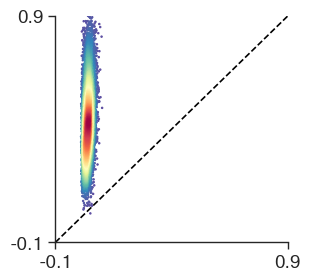

In [56]:
x = sc_cors
y = meta_cors
inds = (~sc_cors.isna()) & (~meta_cors.isna())
x = x[inds]
y = y[inds]

x, y, z = density_2d(x, y)

plt.figure(figsize=[3, 3])
plt.scatter(x, y, s=1, c=z)
sns.despine()
# plt.xlabel('Single-cell correlation')
# plt.ylabel('Meta-cell correlation')
lim = [-0.1, 0.9]
plt.xlim(lim)
plt.ylim(lim)

plt.xticks(lim)
plt.yticks(lim)

plt.plot(lim, lim, color='black', linestyle='--')
plt.savefig(plot_prefix + f'dorc_corrs_cmp.png', dpi=150)
# plt.colorbar()

### Specific examples

In [80]:
from scipy.stats import pearsonr, spearmanr

TAL1: 0.9075
MPO: 0.8232
IRF8: 0.7475


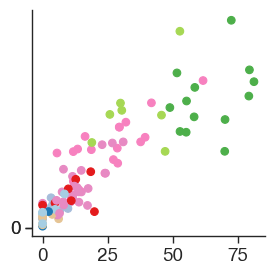

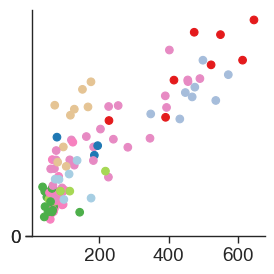

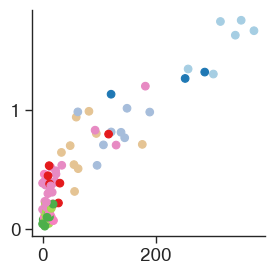

In [82]:
genes = ['TAL1', 'MPO', 'IRF8']
rna_exprs = pd.DataFrame(rna_meta_ad.X.todense(), 
                         index=rna_meta_ad.obs_names, columns=rna_meta_ad.var_names)



for gene in genes:
    
    # Correlated peaks
    p = gene_res[gene]['cor'].idxmax()
    x, y = rna_exprs[gene][gene_scores.index], gene_scores[gene]
    
    plt.figure(figsize=[3, 3])
    plt.scatter(x, y, 
                s=30, #edgecolor='black', linewidths=0.5,
               color=ct_colors[rna_ad.obs['celltype'][x.index]])
    ax = plt.gca()
    sns.despine()
    # plt.xlabel('Metacell expression')
    # plt.ylabel('Metacell accessibility')

    corr = spearmanr(x ,y)[0]
    print(f'{gene}: {corr:.4f}')
#     plt.xticks([0, int((plt.xlim()[1]))])
#     if gene == 'TAL1':
#         plt.ylim([plt.ylim()[0], 50])
    plt.yticks([0, int(plt.ylim()[1])])

    plt.savefig(plot_prefix + f'gene_scores_corrs_meta_{gene}.png', dpi=150)

TAL1: 0.0468
MPO: 0.0568
IRF8: 0.0351


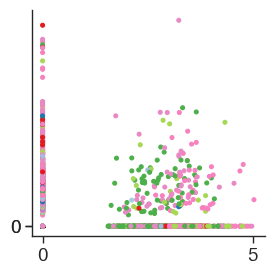

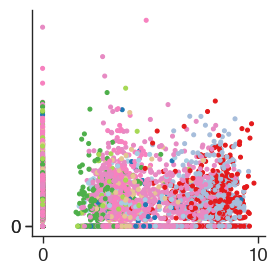

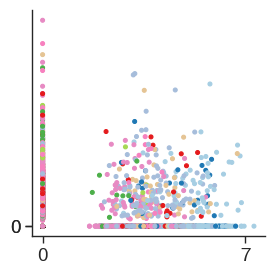

In [86]:
rna_exprs = pd.DataFrame(rna_ad.X.todense(), 
                         index=rna_ad.obs_names, columns=rna_ad.var_names)


for gene in genes:
    
    x, y = rna_exprs[gene][sc_gene_scores.index], sc_gene_scores[gene]
    
    plt.figure(figsize=[3, 3])
    plt.scatter(x, y, s=8,
               color=ct_colors[rna_ad.obs['celltype'][atac_ad.obs_names]])
    ax = plt.gca()
    sns.despine()
    # plt.xlabel('Single cell expression')
    # plt.ylabel('Single cell accessibility')

    corr = spearmanr(x, y)[0]

    print(f'{gene}: {corr:.4f}')
    plt.xticks([0, int((plt.xlim()[1]))])
    plt.yticks([0, int((plt.ylim()[1]))])

    plt.savefig(plot_prefix + f'gene_scores_corrs_sc_{gene}.png', dpi=150)


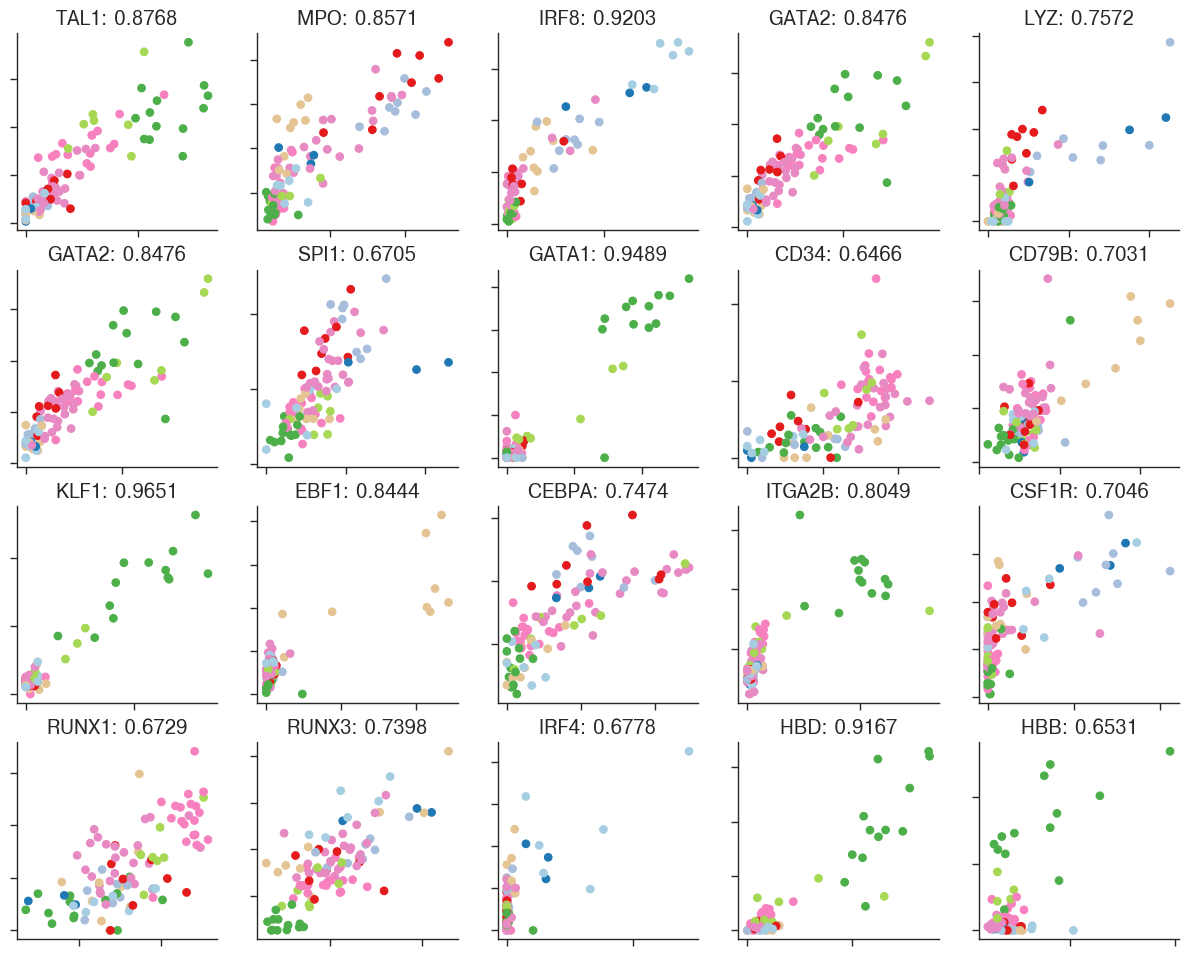

In [69]:
genes = [ 'TAL1', 'MPO', 'IRF8', 'GATA2', 'LYZ',
          'GATA2', 'SPI1', 'GATA1', 'CD34', 'CD79B', 
         'KLF1', 'EBF1', 'CEBPA', 'ITGA2B', 'CSF1R', 
         'RUNX1', 'RUNX3', 'IRF4', 'HBD', 'HBB']
#          'GPC5', 'CUX2', 'FCER1A', 'ANK3', 'BLNK', 
#          'LGALS1', 'BMP6', 'HBD', 'PBX1', 'FREM1']
genes = np.array(genes).reshape([4, 5])

rna_exprs = pd.DataFrame(rna_meta_ad.X.todense(), 
                         index=rna_meta_ad.obs_names, columns=rna_meta_ad.var_names)


fig = plt.figure(figsize=[3 * 5, 3 * 4])
gs = gridspec.GridSpec(genes.shape[0], genes.shape[1])

for i in range(genes.shape[0]):
    for j in range(genes.shape[1]):
        ax = fig.add_subplot(gs[i, j])
        gene = genes[i, j]
        
        # Comparisons
        x, y = rna_exprs[gene][gene_scores.index], gene_scores[gene]
        
        ax.scatter(x, y, 
                    s=30, #edgecolor='black', linewidths=0.5,
                   color=ct_colors[rna_ad.obs['celltype'][x.index].values])
        sns.despine()
        # plt.xlabel('Metacell expression')
        # plt.ylabel('Metacell accessibility')

        corr = pearsonr(x, y)[0]
        ax.set_title(f'{gene}: {corr:.4f}')
#         ax.set_title(f'{gene}')
    #     plt.xticks([0, int((plt.xlim()[1]))])
    #     if gene == 'TAL1':
    #         plt.ylim([plt.ylim()[0], 50])
        ax.set_yticklabels([])
        ax.set_xticklabels([])
plt.savefig(plot_prefix + 'Supp_SEACell_genescores.png', dpi=150)

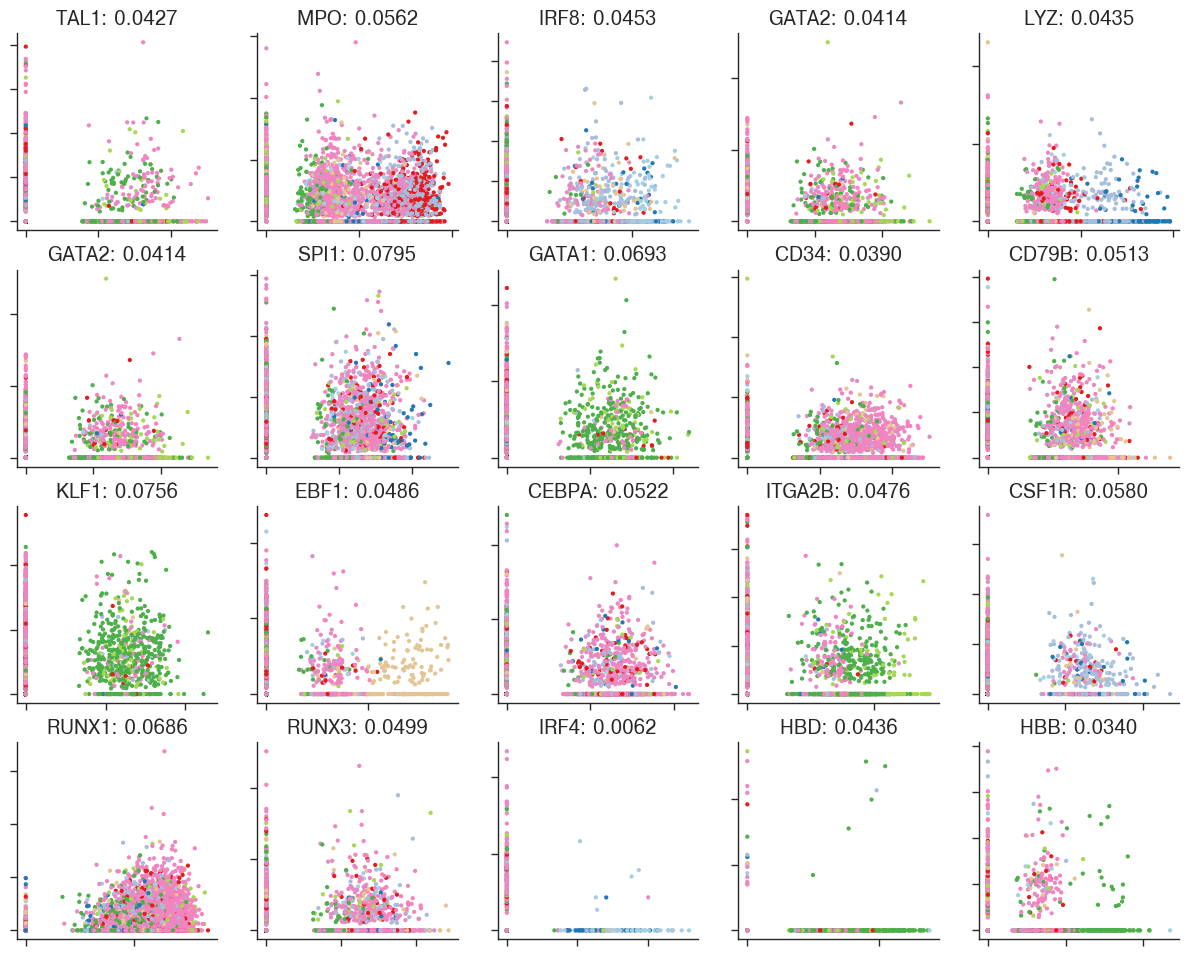

In [71]:
genes = [ 'TAL1', 'MPO', 'IRF8', 'GATA2', 'LYZ',
          'GATA2', 'SPI1', 'GATA1', 'CD34', 'CD79B', 
         'KLF1', 'EBF1', 'CEBPA', 'ITGA2B', 'CSF1R', 
         'RUNX1', 'RUNX3', 'IRF4', 'HBD', 'HBB']
#          'GPC5', 'CUX2', 'FCER1A', 'ANK3', 'BLNK', 
#          'LGALS1', 'BMP6', 'HBD', 'PBX1', 'FREM1']
genes = np.array(genes).reshape([4, 5])

rna_exprs = pd.DataFrame(rna_ad.X.todense(), 
                         index=rna_ad.obs_names, columns=rna_ad.var_names)

fig = plt.figure(figsize=[3 * 5, 3 * 4])
gs = gridspec.GridSpec(genes.shape[0], genes.shape[1])

for i in range(genes.shape[0]):
    for j in range(genes.shape[1]):
        ax = fig.add_subplot(gs[i, j])
        gene = genes[i, j]
        
        # Comparisons
        x, y = rna_exprs[gene][sc_gene_scores.index], sc_gene_scores[gene]
        
        ax.scatter(x, y, 
                    s=5, #edgecolor='black', linewidths=0.5,
                   color=ct_colors[rna_ad.obs['celltype'][x.index].values])
        sns.despine()
        # plt.xlabel('Metacell expression')
        # plt.ylabel('Metacell accessibility')

        corr = pearsonr(x, y)[0]
        ax.set_title(f'{gene}: {corr:.4f}')
#         ax.set_title(f'{gene}')
    #     plt.xticks([0, int((plt.xlim()[1]))])
    #     if gene == 'TAL1':
    #         plt.ylim([plt.ylim()[0], 50])
        ax.set_yticklabels([])
        ax.set_xticklabels([])
plt.savefig(plot_prefix + 'Supp_SingleCell_genescores.png', dpi=150)

## Correlation comparison - singlecell gene scores

In [56]:
from scipy.stats import spearmanr

In [57]:
sc_gene_scores_df = pd.DataFrame(atac_ad.obsm['GeneScores'], 
            index=atac_ad.obs_names, columns=atac_ad.uns['GeneScoresColums'])

In [48]:
rna_exprs = pd.DataFrame(rna_ad.X.todense(), 
                         index=rna_ad.obs_names, columns=rna_ad.var_names)
# Correlations
sc_cors = pd.Series(0.0, index=sc_gene_scores.columns)
for gene in tqdm(sc_cors.index):
    sc_cors[gene] = spearmanr(rna_exprs[gene], sc_gene_scores_df[gene])[0]

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [49]:
from scipy.stats import gaussian_kde


def density_2d(x, y):
    """return x and y and their density z, sorted by their density (smallest to largest)
    :param x:
    :param y:
    :return:
    """
    xy = np.vstack([np.ravel(x), np.ravel(y)])
    z = gaussian_kde(xy)(xy)
    i = np.argsort(z)
    return np.ravel(x)[i], np.ravel(y)[i], z[i]


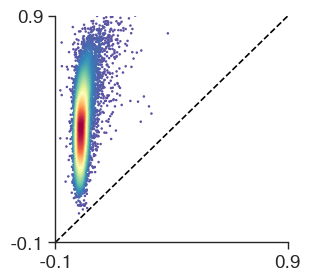

In [52]:
x = sc_cors
y = meta_cors
inds = (~sc_cors.isna()) & (~meta_cors.isna())
x = x[inds]
y = y[inds]

x, y, z = density_2d(x, y)

plt.figure(figsize=[3, 3])
plt.scatter(x, y, s=1, c=z)
sns.despine()
# plt.xlabel('Single-cell correlation')
# plt.ylabel('Meta-cell correlation')
lim = [-0.1, 0.9]
plt.xlim(lim)
plt.ylim(lim)

plt.xticks(lim)
plt.yticks(lim)

plt.plot(lim, lim, color='black', linestyle='--')
plt.savefig(plot_prefix + f'dorc_corrs_cmp_archr_gs.png', dpi=150)
# plt.colorbar()

### Specific examples

In [53]:
from scipy.stats import pearsonr, spearmanr

In [54]:
genes = ['TAL1', 'MPO', 'IRF8']

TAL1: 0.0468
MPO: 0.0568
IRF8: 0.0351


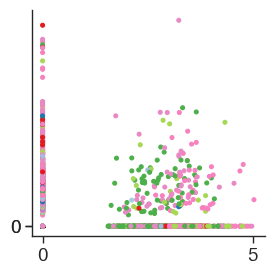

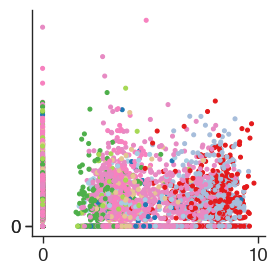

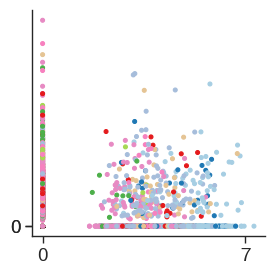

In [55]:
rna_exprs = pd.DataFrame(rna_ad.X.todense(), 
                         index=rna_ad.obs_names, columns=rna_ad.var_names)


for gene in genes:
    
    x, y = rna_exprs[gene][sc_gene_scores.index], sc_gene_scores[gene]
    
    plt.figure(figsize=[3, 3])
    plt.scatter(x, y, s=8,
               color=ct_colors[rna_ad.obs['celltype'][atac_ad.obs_names]])
    ax = plt.gca()
    sns.despine()
    # plt.xlabel('Single cell expression')
    # plt.ylabel('Single cell accessibility')

    corr = spearmanr(x, y)[0]

    print(f'{gene}: {corr:.4f}')
    plt.xticks([0, int((plt.xlim()[1]))])
    plt.yticks([0, int((plt.ylim()[1]))])

    plt.savefig(plot_prefix + f'gene_scores_corrs_sc_{gene}_archr_gs.png', dpi=150)


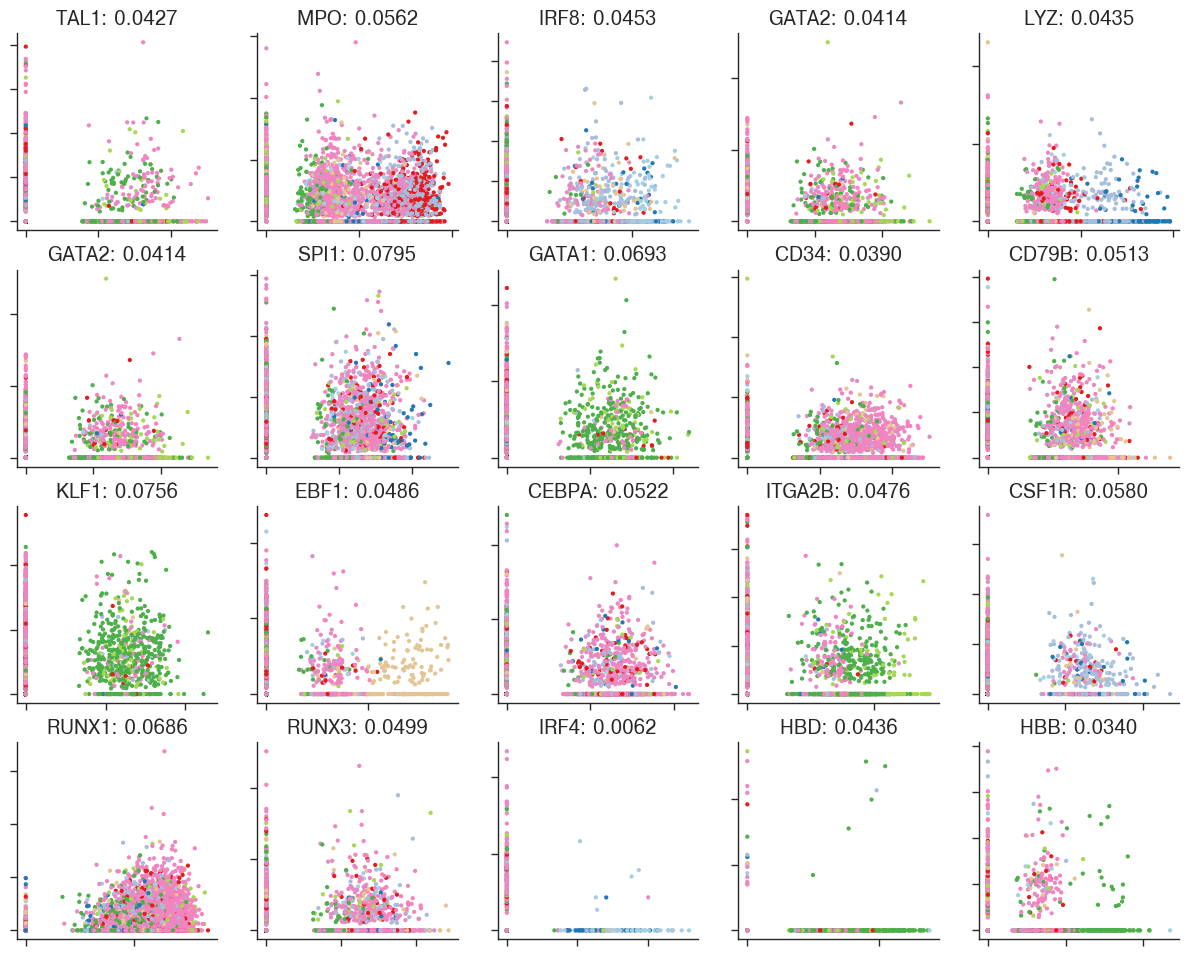

In [71]:
genes = [ 'TAL1', 'MPO', 'IRF8', 'GATA2', 'LYZ',
          'GATA2', 'SPI1', 'GATA1', 'CD34', 'CD79B', 
         'KLF1', 'EBF1', 'CEBPA', 'ITGA2B', 'CSF1R', 
         'RUNX1', 'RUNX3', 'IRF4', 'HBD', 'HBB']
#          'GPC5', 'CUX2', 'FCER1A', 'ANK3', 'BLNK', 
#          'LGALS1', 'BMP6', 'HBD', 'PBX1', 'FREM1']
genes = np.array(genes).reshape([4, 5])

rna_exprs = pd.DataFrame(rna_ad.X.todense(), 
                         index=rna_ad.obs_names, columns=rna_ad.var_names)

fig = plt.figure(figsize=[3 * 5, 3 * 4])
gs = gridspec.GridSpec(genes.shape[0], genes.shape[1])

for i in range(genes.shape[0]):
    for j in range(genes.shape[1]):
        ax = fig.add_subplot(gs[i, j])
        gene = genes[i, j]
        
        # Comparisons
        x, y = rna_exprs[gene][sc_gene_scores.index], sc_gene_scores[gene]
        
        ax.scatter(x, y, 
                    s=5, #edgecolor='black', linewidths=0.5,
                   color=ct_colors[rna_ad.obs['celltype'][x.index].values])
        sns.despine()
        # plt.xlabel('Metacell expression')
        # plt.ylabel('Metacell accessibility')

        corr = pearsonr(x, y)[0]
        ax.set_title(f'{gene}: {corr:.4f}')
#         ax.set_title(f'{gene}')
    #     plt.xticks([0, int((plt.xlim()[1]))])
    #     if gene == 'TAL1':
    #         plt.ylim([plt.ylim()[0], 50])
        ax.set_yticklabels([])
        ax.set_xticklabels([])
plt.savefig(plot_prefix + 'Supp_SingleCell_archr_genescores.png', dpi=150)

# Coverage related

## Coverage plot functions

In [64]:
import tabix
import subprocess

import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle, Arc
from matplotlib.collections import PatchCollection

In [65]:
def compute_coverage(fragments_files, region, barcodes, out_prefix, 
                     smooth=None, normalize=False, frag_type='All'):

    # Bed file
    bed_file = open(out_prefix + '.bed', 'w')

    for sample in fragments_files.keys():
        tb = tabix.open(fragments_files[sample])
        records = tb.querys(region)
    
        # Iterate and write bed file
        for record in records:
            if record[3] in barcodes[sample]:
                # Write to bed file if the read is NFR
                if frag_type == 'NFR' and int(record[2]) - int(record[1]) > 145:
                    continue 
                if frag_type == 'NUC' and int(record[2]) - int(record[1]) <= 145:
                    continue 

                # Write to bed file
                line = record[0] + '\t' + record[1] + '\t' + record[2] + '\n'
                bed_file.writelines(line)

    # Close bed file
    bed_file.close()

    # Region to bed
    line = region.replace(':', '\t').replace('-', '\t') + '\n'
    bed_file = open(out_prefix + '.region.bed', 'w')
    bed_file.writelines(line)
    bed_file.close()

    # Coverage
    out_file = open(out_prefix + '.coverage.bed', 'w')
    args = ['bedtools', 'coverage', '-a', out_prefix + '.region.bed', '-b',
            out_prefix + '.bed', '-d']
    subprocess.call(args, stdout=out_file)
    out_file.close()

    # Read coverage
    df = pd.read_csv(out_prefix + '.coverage.bed', sep='\t', header=None)
    coverage = pd.Series(df[4].values, index=df[1] + df[3] - 1)
    coverage.attrs['chr'] = df[0][0]

    # Smooth if specified
    if smooth:
        coverage = coverage.rolling(smooth).mean()
        coverage[coverage.isnull()] = coverage.iloc[smooth]

    if normalize:
        nFrags = 0
        for sample in barcodes.index:
            sample_bc = (atac_ad.obs_names.str.contains(sample)) & (atac_ad.obs['FragSample'].isin(barcodes[sample]))
            nFrags += atac_ad.obs['nFrags'][sample_bc].sum()
        norm = 1e6 / nFrags
        coverage = coverage * norm

    # Clean up
    os.unlink(out_prefix + '.bed')
    os.unlink(out_prefix + '.coverage.bed')
    os.unlink(out_prefix + '.region.bed')

    return coverage

In [86]:
sns.color_palette("viridis", as_cmap=True)

In [67]:
sns.dark_palette("#69d", reverse=True, as_cmap=True)

In [87]:
# Plot coverage
def _plot_coverage(coverage, track_name='Coverage', ax=None, color='#ff7f00',
                   min_coverage=0, ylim=None, fill=True, linestyle='-', y_font=None):
    if ax is None:
        plt.figure()
        ax = plt.gca()

    if y_font is not None:
        ax.tick_params(axis='y', labelsize=y_font)

    # Plot and fill
    values = coverage
    values[values <= min_coverage] = 0
    if fill:
        ax.plot(coverage.index, values, color='black', linewidth=0.5)
        ax.fill_between(coverage.index, 0, values, color=color)
#         ax.set_ylabel(track_name)
    else:
        ax.plot(coverage.index, values, color=color, 
                linestyle=linestyle, linewidth=0.75)

    # Scale
    if ylim is not None:
        ax.set_ylim(ylim)
    sns.despine(ax=ax)

    
# BED plot
def _plot_bed(plot_peaks, track_name="Bed", ax=None, facecolor='#ff7f00'):

    if ax is None:
        plt.figure()
        ax = plt.gca()
    
    rects = []
    if len(plot_peaks) > 0:
        for s, e in zip(plot_peaks.Start, plot_peaks.End):
            rects.append(Rectangle((s, -0.45), e - s, 0.9))

    # Add rectangles
    # Dummy scatter
    pc = PatchCollection(rects, facecolor=facecolor, edgecolor='black')
    ax.add_collection(pc)

    # Axis annotation
    ax.set_ylim([-1, 1])
    sns.despine(ax=ax, bottom=True)
    ax.set_yticks([])
#     ax.set_ylabel(track_name, rotation=0)
    ax.axes.get_xaxis().set_visible(False)


# Gene plot
def _plot_gene(genes, ax=None, track_name='Genes', facecolor='#377eb8',
               exon_height=0.9, utr_height=0.4):
    # Setup plot
    if ax is None:
        plt.figure()
        ax = plt.gca()

    for gene in np.unique(genes.gene_name):
        gene_pr = genes[genes.gene_name == gene]

        # Plot lines
        gs, ge = gene_pr[gene_pr.Feature == 'gene'].Start.values[0], gene_pr[gene_pr.Feature == 'gene'].End.values[0]
        ax.plot([gs, ge], [0, 0], color='black')
        ax.set_ylim([-1, 1])
#         ax.text((gs + ge) / 2,
#                 -(exon_height + utr_height), gene, horizontalalignment='center')

        # UTRs
        utrs = gene_pr[gene_pr.Feature.astype(str).str.contains('utr')]
        if len(utrs) > 0:
            rects = []
            for s, e in zip(utrs.Start, utrs.End):
                rects.append(Rectangle((s, -utr_height / 2), e - s, utr_height))
            ax.add_collection(PatchCollection(rects, facecolor=facecolor, edgecolor='black'))

        # CDS
        cds = gene_pr[gene_pr.Feature.astype(str).str.contains('CDS')]
        if len(cds) == 0:
            cds = gene_pr[gene_pr.Feature.astype(str).str.contains('exon')]
        rects = []
        for s, e in zip(cds.Start, cds.End):
            rects.append(Rectangle((s, -exon_height / 2), e - s, exon_height))
        ax.add_collection(PatchCollection(rects, facecolor=facecolor, edgecolor='black'))

        # Arrow indicating direction
#         rs, re = ax.get_xlim()
#         if gene_pr.stranded:
#             s, e = cds.Start.values[0], cds.End.values[0]
#             if gene_pr.Strand.values[0] == '+':
#                 ax.plot([s, e], np.repeat(-0.65, 2), color='red', linewidth=1, alpha=1)
#                 ax.plot([e - (re - rs) / 100, e], [-0.95, -0.65], color='red', linewidth=1, alpha=1)
#                 ax.plot([e - (re - rs) / 100, e], [-0.35, -0.65], color='red', linewidth=1, alpha=1)
#             else:
#                 ax.plot([s, e], np.repeat(-0.65, 2), color='red', linewidth=1, alpha=1)
#                 ax.plot([s + (re - rs) / 100, s], [-0.95, -0.65], color='red', linewidth=1, alpha=1)
#                 ax.plot([s + (re - rs) / 100, s], [-0.35, -0.65], color='red', linewidth=1, alpha=1)

    # Axis clean up
#     ax.set_ylabel(track_name)
    sns.despine(ax=ax)
    ax.set_yticks([])
    
    
# Links plot
def _plot_links(links, ax):
    for start, end, cor in zip(links['start'], links['end'], links['cor']):
        center = (start + end) / 2
        width = np.abs(center - start) * 2

        a = Arc((center, 0), width,  width, 
                0, 180, 360, lw=1.25,
                color=sns.color_palette("viridis", as_cmap=True)(cor))
#                 color=sns.dark_palette("#", reverse=True, as_cmap=True)(cor))

        ax.add_patch(a)

    ax.set_ylim([np.min(-np.abs((links['end'] + start)/2 - start)) - 100, 0])
    ax.set_axis_off()

In [83]:
def plot_coverage(barcode_groups, region, fragments_files,
                  peak_groups=None, genes=None, highlight_peaks=None,
                  min_coverage=0, smooth=None, common_scale=False,
                  plot_cov_size=2, plot_bed_size=0.75, collapsed=False,
                  coverage_colors=None, fig_width=15, frag_type='All', 
                  normalize=True, links=None, y_font=None):

    # Determine coverages
    coverages = dict()
    for k in barcode_groups.index:
        iter_norm = normalize
        if k == 'Single-cell':
            iter_norm = False
        coverages[k] = compute_coverage(fragments_files, region, barcode_groups[k],
                                        '/tmp/test', smooth, iter_norm, frag_type)
    # Plot
    n_rows = len(coverages)
    size = plot_cov_size * n_rows
    ratios = np.repeat(1, n_rows)
    if collapsed:
        n_rows = 1
        size = plot_cov_size * 4
        ratios = np.repeat(4, 1)
    if peak_groups is not None:
        size += plot_bed_size * len(peak_groups)
        n_rows += len(peak_groups)
        ratios = np.append(ratios, np.repeat(plot_bed_size / plot_cov_size, len(peak_groups)))
    if links is not None:
        link_frac = 0.75
        size += plot_cov_size * link_frac
        n_rows += 1
        ratios = np.append(ratios, link_frac)
    if genes is not None:
        size += plot_bed_size
        n_rows += 1
        ratios = np.append(ratios, plot_bed_size / plot_cov_size)

    # Colors
    if coverage_colors is None:
        coverage_colors = pd.Series(sns.color_palette('Set2', len(coverages)).as_hex(),
                                    index=barcode_groups.index)

    # Y min and max
    ylim = None
    if common_scale:
        ymin = np.inf
        ymax = -np.inf
        for row in barcode_groups.index:
            if row == 'Single-cell':
                continue
            ymin = np.min([ymin, np.min(coverages[row])])
            ymax = np.max([ymax, np.max(coverages[row])])
        ylim = [ymin, ymax]


    # Region pyranges
    pr_region = pr.from_dict({'Chromosome': [region.split(':')[0]],
                              'Start': [int(region.split(':')[1].split('-')[0])],
                              'End': [int(region.split('-')[1])]})
    if highlight_peaks is not None:
        highlight_peaks = highlight_peaks.overlap(pr_region)
        
    # Plot
    fig = plt.figure(figsize=[fig_width, size])
    gs = gridspec.GridSpec(n_rows, 1, height_ratios=ratios, figure=fig)

    # Coverages
    plot_index = 0
    if collapsed:
        ax = fig.add_subplot(gs[plot_index, 0])
        ax.set_xlim([pr_region.Start[0], pr_region.End[0]])
        plot_index += 1

    for row in barcode_groups.index:
        # Create subplot
        if not collapsed:
            ax = fig.add_subplot(gs[plot_index, 0])
            ax.set_xlim([pr_region.Start[0], pr_region.End[0]])
            plot_index += 1

        iter_ylim = ylim
        if row == 'Single-cell':
            iter_ylim = [0, 2]
        _plot_coverage(coverages[row], row, ax, coverage_colors[row],
                       min_coverage, iter_ylim, not collapsed, y_font=y_font)

        # Highlight peaks
        if highlight_peaks is not None:
            for s, e in zip(highlight_peaks.Start, highlight_peaks.End):
                rect = Rectangle((s, 0), e - s, ax.get_ylim()[1],
                                 color='black', alpha=0.07, zorder=1000)
                ax.add_patch(rect)

        # Reset axis
        if plot_index != n_rows:
            ax.set_xticks([])


    # Region pyranges
    pr_region = pr.from_dict({'Chromosome': [region.split(':')[0]],
                              'Start': [int(region.split(':')[1].split('-')[0])],
                              'End': [int(region.split('-')[1])]})

    # Peaks
    if peak_groups is not None:
        for row in peak_groups.index:
            plot_peaks = peak_groups[row].overlap(pr_region)

            ax = fig.add_subplot(gs[plot_index, 0])
            ax.set_xlim([pr_region.Start[0], pr_region.End[0]])
            plot_index += 1

            _plot_bed(plot_peaks, row, ax, facecolor=coverage_colors[row])
    
    
    # Links
    if links is not None:
        ax = fig.add_subplot(gs[plot_index, 0])
        ax.set_xlim([pr_region.Start[0], pr_region.End[0]])
        plot_index += 1

        _plot_links(links, ax)

    # Genes
    if genes is not None:
        genes = genes.overlap(pr_region)
        genes.End[genes.End > pr_region.End[0]] = pr_region.End[0]
        genes.Start[genes.Start < pr_region.Start[0]] = pr_region.Start[0]


        # Setup plot
        ax = fig.add_subplot(gs[plot_index, 0])
        ax.set_xlim([pr_region.Start[0], pr_region.End[0]])
        plot_index += 1

        _plot_gene(genes, ax, track_name='Genes')

        # Axis clean up
#         ax.set_ylabel('Genes', rotation=0)
        sns.despine(ax=ax)
        ax.set_yticks([])



    # Clean up axis annotation
    ax.axes.get_xaxis().set_visible(True)
    locs = ax.get_xticks()[[0, -1]]
#     locs[0] += 10000
#     locs[1] -= 10000
    ax.set_xticks(locs)
    ax.set_xticklabels([str(int(t)) for t in ax.get_xticks()])
    ax.set_xlabel(region.split(':')[0])



## GTF

In [70]:
gtf = pr.read_gtf(os.path.expanduser('~/data/genomes/hg38.gtf'))
gtf.Chromosome = 'chr' + gtf.Chromosome.astype(str)

## Fragment files

In [71]:
frag_dir = os.path.expanduser('~/projects/metacells/data/CD34/Multiome/')

fragment_files = dict()
fragment_files['cd34_multiome_rep1'] = frag_dir + 'rep1/atac_fragments.tsv.gz'
fragment_files['cd34_multiome_rep2'] = frag_dir + 'rep2/atac_fragments.tsv.gz'

## Chromsizes

In [72]:
chromsizes = os.path.expanduser('~/projects/metacells/data/CD34/ATAC/chromsizes')

## Peaks

In [73]:
peak_groups = pd.Series()
peak_groups['Peaks'] = pyranges_from_strings(atac_ad.var_names)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [74]:
atac_ad.obs['FragSample'] = atac_ad.obs_names.str.split('#').str.get(1).astype(str)

# Peak calling demonstration

In [75]:
# ct_order = ['HSC', 'HMP', 'MEP', 'Ery', 'CLP', 'Mono', 'cDC', 'pDC']
ct_order = ['HSC', 'MEP', 'Ery']

In [76]:
barcode_groups = pd.Series([], dtype=object)
for test_ct in ct_order:
    # Cell type cells
    cells = rna_ad.obs_names[rna_ad.obs['celltype'] == test_ct]
    barcode_groups[test_ct] = pd.Series([], dtype=object)
    for r in ['cd34_multiome_rep1', 'cd34_multiome_rep2']:
        barcode_groups[test_ct][r] = atac_ad.obs['FragSample'][cells][cells.str.contains(r)].values
    
peak_groups = pd.Series()
peak_groups['Peaks'] = pyranges_from_strings(atac_ad.var_names)
# peak_groups['Peaks-vanilla'] = pyranges_from_strings(atac_archr_vanilla.var_names)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if __name__ == '__main__':


In [77]:
cluster_colors = ct_colors.copy()
cluster_colors['Peaks'] = '#FDB396'
# cluster_colors['Peaks-vanilla'] = '#FDB396'

## NFR

In [78]:
pval_cutoff = 1e-1
cor_cutoff = 0.2

anchor_gene = 'GATA2'
meta_peaks = gene_res[anchor_gene].index[gene_res[anchor_gene]['pval'] < pval_cutoff].sort_values()
meta_peaks = meta_peaks[gene_res[anchor_gene].loc[meta_peaks, 'cor'] > cor_cutoff]
# meta_peaks = meta_peaks[1:]

In [79]:
# region = meta_peaks[0].split('-')[0] + '-' + meta_peaks[-1].split('-')[1]
region = 'chr3:128432235-128585707'

pr_region = pr.from_dict({'Chromosome': [region.split(':')[0]],
                              'Start': [int(region.split(':')[1].split('-')[0])],
                              'End': [int(region.split('-')[1])]})



genes = gtf.intersect(pr_region)
genes = genes[genes.gene_name.isin([anchor_gene])]

In [80]:
cors = gene_res[anchor_gene].loc[meta_peaks, 'cor']

# Gene start
sub_gtf = genes[genes.gene_name == anchor_gene]
gene_start = sub_gtf.Start.iloc[0]  if sub_gtf.Strand.iloc[0] == '+' else sub_gtf.End.iloc[0]

# Peak centers
meta_pr = pyranges_from_strings(meta_peaks)
meta_pr = meta_pr.overlap(pr_region)
ends = (meta_pr.End + meta_pr.Start) / 2

links = pd.DataFrame([np.repeat(gene_start, len(ends)), ends.values, cors[pyranges_to_strings(meta_pr)].values]).T
links.columns = ['start', 'end', 'cor']

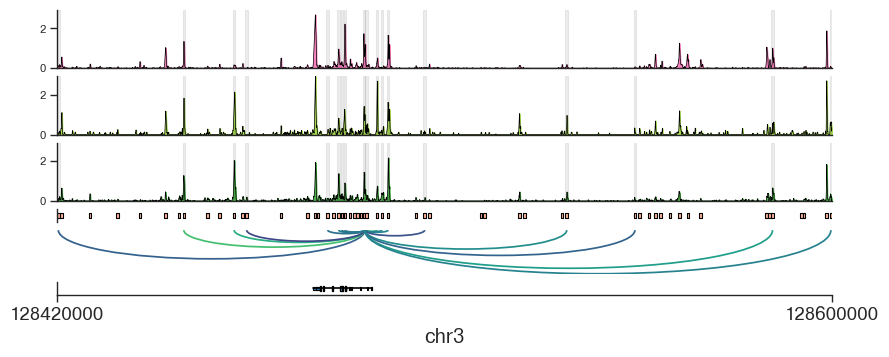

In [88]:
plot_coverage(barcode_groups, region, fragment_files, 
              peak_groups, genes=genes, highlight_peaks=meta_pr,
              common_scale=True, smooth=75, 
              fig_width=10,  plot_cov_size = 0.9, plot_bed_size=0.2,
              frag_type='NFR', normalize=True, 
              coverage_colors=cluster_colors, 
              min_coverage=0.01, links=links, y_font=8)
plt.savefig(plot_prefix + f'{anchor_gene}_nfr_coverage_ct_subset.png', dpi=150)

## All frags

In [89]:
peak_groups['Peaks'] = pyranges_from_strings(atac_archr_vanilla.var_names)

In [90]:
cor_cutoff = 0.02

meta_peaks = sc_gene_res[anchor_gene].index[sc_gene_res[anchor_gene]['pval'] < pval_cutoff].sort_values()
meta_peaks = meta_peaks[sc_gene_res[anchor_gene].loc[meta_peaks, 'cor'] > cor_cutoff]
# meta_peaks = meta_peaks[1:]

In [91]:
cors = sc_gene_res[anchor_gene].loc[meta_peaks, 'cor']

# Gene start
sub_gtf = genes[genes.gene_name == anchor_gene]
gene_start = sub_gtf.Start.iloc[0]  if sub_gtf.Strand.iloc[0] == '+' else sub_gtf.End.iloc[0]

# Peak centers
meta_pr = pyranges_from_strings(meta_peaks)
meta_pr = meta_pr.overlap(pr_region)
ends = (meta_pr.End + meta_pr.Start) / 2

links = pd.DataFrame([np.repeat(gene_start, len(ends)), ends.values, cors[pyranges_to_strings(meta_pr)].values]).T
links.columns = ['start', 'end', 'cor']

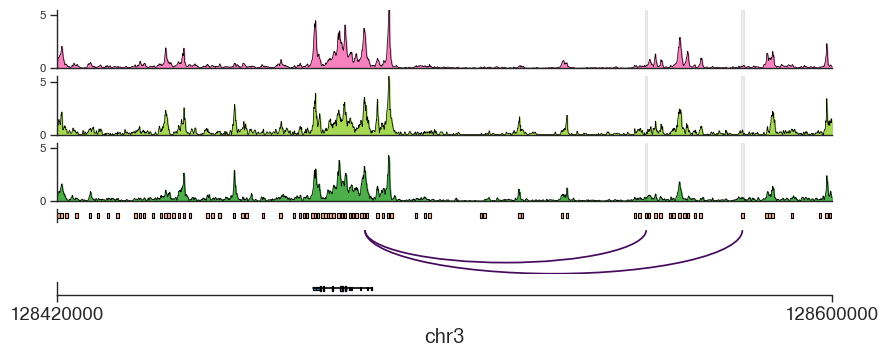

In [92]:
plot_coverage(barcode_groups, region, fragment_files, 
              peak_groups, genes=genes, highlight_peaks=meta_pr,
              common_scale=True, smooth=75, 
              fig_width=10,  plot_cov_size = 0.9, plot_bed_size=0.2,
              frag_type='All', normalize=True, 
              coverage_colors=cluster_colors, 
              min_coverage=0.01, links=links, y_font=8)
plt.savefig(plot_prefix + f'{anchor_gene}_all_coverage_ct_subset.png', dpi=150)

## All cell types

In [70]:
# region = meta_peaks[0].split('-')[0] + '-' + meta_peaks[-1].split('-')[1]
region = 'chr3:128,472,344-128,500,733'.replace(',', '')

region = 'chr19:12,878,591-12,893,923'.replace(',', '')
anchor_gene = 'KLF1'

pr_region = pr.from_dict({'Chromosome': [region.split(':')[0]],
                              'Start': [int(region.split(':')[1].split('-')[0])],
                              'End': [int(region.split('-')[1])]})



genes = gtf.intersect(pr_region)
genes = genes[genes.gene_name.isin([anchor_gene])]

In [71]:
ct_order = ['HSC', 'HMP', 'MEP', 'Ery', 'CLP', 'Mono', 'DCPre', 'cDC', 'pDC']

In [72]:
barcode_groups = pd.Series([], dtype=object)
for test_ct in ct_order:
    # Cell type cells
    cells = rna_ad.obs_names[rna_ad.obs['celltype'] == test_ct]
    barcode_groups[test_ct] = pd.Series([], dtype=object)
    for r in ['cd34_multiome_rep1', 'cd34_multiome_rep2']:
        barcode_groups[test_ct][r] = atac_ad.obs['FragSample'][cells][cells.str.contains(r)].values
    
peak_groups = pd.Series()
peak_groups['Peaks'] = pyranges_from_strings(atac_ad.var_names)
# peak_groups['Peaks-vanilla'] = pyranges_from_strings(atac_archr_vanilla.var_names)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if __name__ == '__main__':


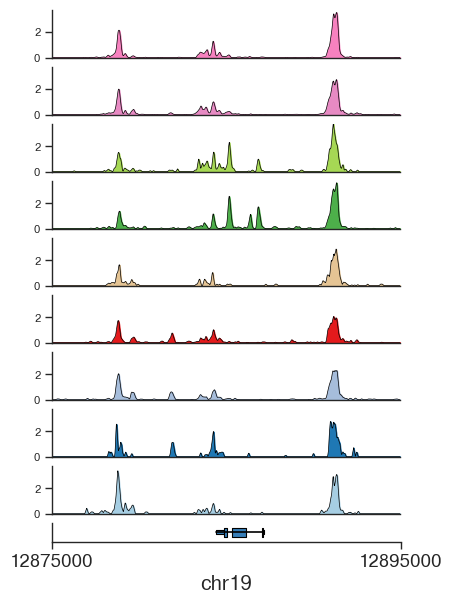

In [76]:
plot_coverage(barcode_groups, region, fragment_files, 
              peak_groups=None, genes=genes, highlight_peaks=None,
              common_scale=True, smooth=75, 
              fig_width=4.5,  plot_cov_size = 0.75, plot_bed_size=0.3,
              frag_type='NFR', normalize=True, 
              coverage_colors=cluster_colors, 
              min_coverage=0.01, links=None, y_font=8)
plt.savefig(plot_prefix + f'{anchor_gene}_nfr_coverage_all_ct.png', dpi=150)

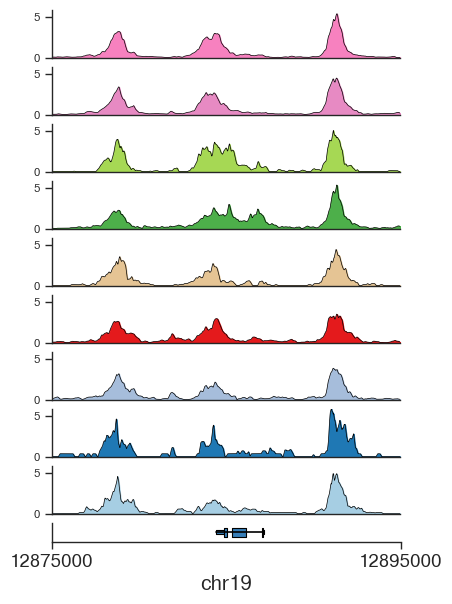

In [77]:
plot_coverage(barcode_groups, region, fragment_files, 
              peak_groups=None, genes=genes, highlight_peaks=None,
              common_scale=True, smooth=75, 
              fig_width=4.5,  plot_cov_size = 0.75, plot_bed_size=0.3,
              frag_type='All', normalize=True, 
              coverage_colors=cluster_colors, 
              min_coverage=0.01, links=None, y_font=8)
plt.savefig(plot_prefix + f'{anchor_gene}_all_coverage_all_ct.png', dpi=150)

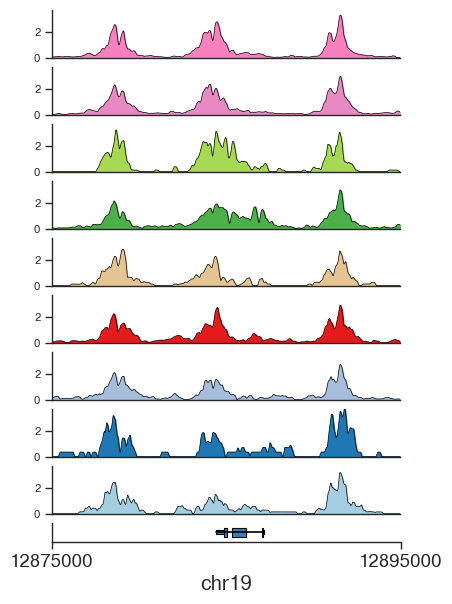

In [79]:
plot_coverage(barcode_groups, region, fragment_files, 
              peak_groups=None, genes=genes, highlight_peaks=None,
              common_scale=True, smooth=75, 
              fig_width=4.5,  plot_cov_size = 0.75, plot_bed_size=0.3,
              frag_type='NUC', normalize=True, 
              coverage_colors=cluster_colors, 
              min_coverage=0.01, links=None, y_font=8)
plt.savefig(plot_prefix + f'{anchor_gene}_nuc_coverage_all_ct.png', dpi=150)